# Evaluación inicial de modelos de imagen TensorFlow Lite

Este notebook sirve para probar el funcionamiento de un modelo de imagen TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

from image_model_evaluation import COLOR_MODE, DIGITS

## Parámetros
Parámetros que se utilizan para el test.

In [2]:
quantized = True
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"
model_name = f"MicroImgDataModelQAT"
# model_name = f"MicroImgDataModel"


label_index_path = f"{label_index_dir}/{model_name}.joblib"
test_dir = f"{project_dir}/samples/microcontroller/preprocessed image/test"

if quantized and model_name[-3:] != "QAT":
    model_name = f"{model_name}Quant"

model_path = f"{saved_models_dir}/tensorflow lite/{model_name}.tflite"

show_interval = 5

## Carga del modelo
Cargamos un modelo de TensorFlow Lite.

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(input_details)
print(output_details)

class_names = load(label_index_path)
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 96, 96,  1], dtype=int32), 'shape_signature': array([-1, 96, 96,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.9792773723602295, -128), 'quantization_parameters': {'scales': array([0.9792774], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 35, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.05772193521261215, 3), 'quantization_parameters': {'scales': array([0.05772194], dtype=float32), 'zero_points': array([3], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

Testing 24 images from class mask.


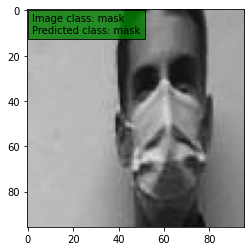

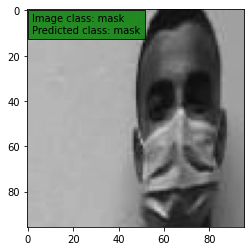

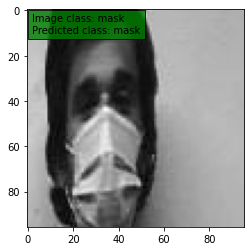

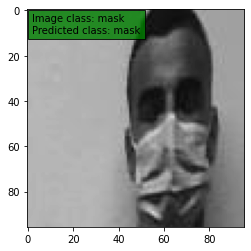

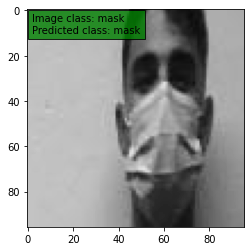

Testing 24 images from class face.


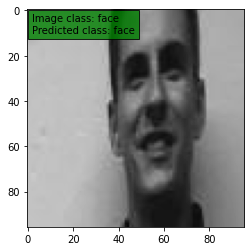

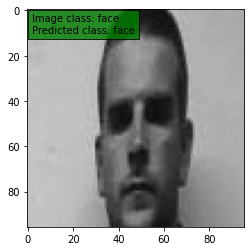

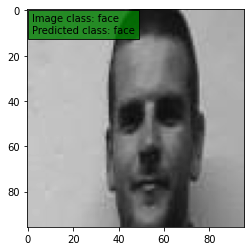

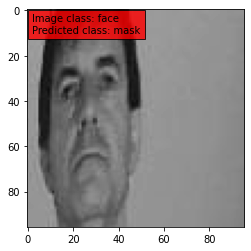

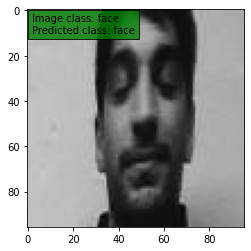

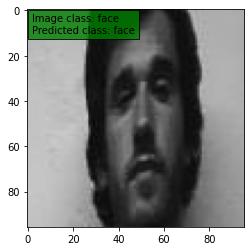

Testing 21 images from class nothing.


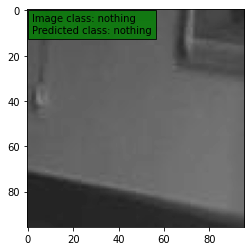

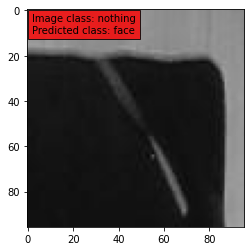

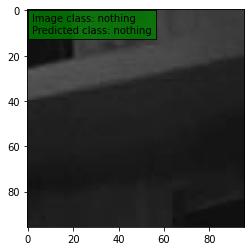

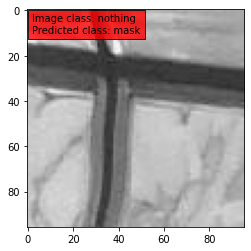

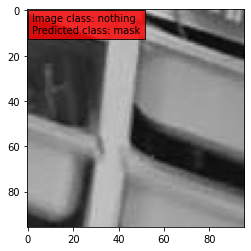

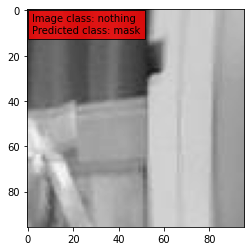

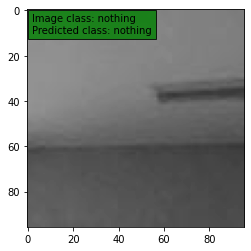

In [4]:
predictions = []
true_labels = []
times = []

classes = os.listdir(test_dir)
show_counter = 0

for name in classes:
    class_dir = f"{test_dir}/{name}"
    files = os.listdir(class_dir)
    print(f"Testing {len(files)} images from class {name}.")
    class_index = class_indexes[name]
    for file in files:
        true_labels.append(class_index)

        file_path = f"{test_dir}/{name}/{file}"

        img = load_img(file_path, color_mode=COLOR_MODE)
        img_array = img_to_array(img)

        if quantized:
            input_scale, input_zero_point = input_details["quantization"]
            img_array = img_array / input_scale + input_zero_point

        img_array = np.expand_dims(img_array, axis=0).astype(input_details["dtype"])


        interpreter.set_tensor(input_details["index"], img_array)

        t_ini = time.time()
        interpreter.invoke()
        t_end = time.time()
        elapsed = (t_end - t_ini) * 1000  # ms
        times.append(elapsed)

        prediction = interpreter.get_tensor(output_details["index"])[0]

        if quantized:
            score = prediction
            score_word = "score"
        else:
            score = tf.nn.softmax(prediction)
            score_word = "confidence"

        predicted_class = prediction.argmax()
        predictions.append(predicted_class)
        prediction_score = np.max(score)

        if show_counter % show_interval == 0 or predicted_class != class_index:
            if predicted_class == class_index:
                text_color = "green"
            else:
                text_color = "red"
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.text(2, 10, f"Image class: {name}\nPredicted class: {class_names[predicted_class]}", color="black",
                     bbox=dict(facecolor=text_color, alpha=0.8))
            plt.show()

        show_counter +=1

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras. Se muestran algunos ejemplos
correctos y todos los casos donde el modelo falla en la predicción.

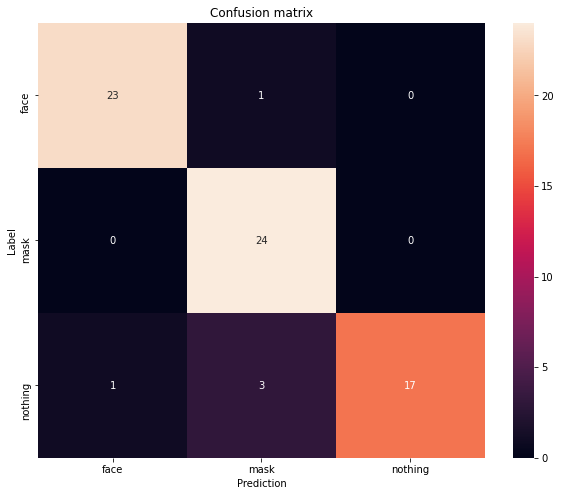

              precision    recall  f1-score   support

        face    0.95833   0.95833   0.95833        24
        mask    0.85714   1.00000   0.92308        24
     nothing    1.00000   0.80952   0.89474        21

    accuracy                        0.92754        69
   macro avg    0.93849   0.92262   0.92538        69
weighted avg    0.93582   0.92754   0.92671        69

Model size 45.5 Kb
Average time: 10.537493056145268 ms
Max time: 36.21840476989746 ms
Min time: 8.586645126342773 ms


In [5]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names, digits=DIGITS))

avg_time = sum(times) / len(times)
max_time = max(times)
min_time = min(times)

print(f"Model size {os.path.getsize(model_path) / 1024} Kb")

print(f"Average time: {avg_time} ms\nMax time: {max_time} ms\nMin time: {min_time} ms")

